In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.patches import Polygon, Patch


In [2]:
# based on mbr_idxs, grid_info return all x,y of a grid
def grid_cols_rows(mbr_idxs, grid_info):
    x_s = []
    for i in range(mbr_idxs['xmin_idx'], mbr_idxs['xmax_idx'] + 1):
        x = grid_info['xmin'] + i * grid_info['step']
        x_s.append(x)

    y_s = []
    for i in range(mbr_idxs['ymin_idx'], mbr_idxs['ymax_idx'] + 1):
        y = grid_info['ymin'] + i * grid_info['step']
        y_s.append(y)
    return x_s,  y_s

# read a polygon in the below format
def read_polygon(filename):
    ''' input file format:
    segment {x1} {y1} {x2} {y2} (optionally)    
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    polygon = list()
    segment = None
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        start_idx = 0
        first_line = lines[0].split()
        if first_line[0] == "segment":
            segment = [ [float(first_line[1]), float(first_line[2])], [float(first_line[3]), float(first_line[4])] ]
            start_idx = 1
        for line in lines[start_idx:]:
            if len(line.split()) != 2:
                break
            x = line.split()[0]
            y = line.split()[1]
            polygon.append((float(x), float(y)))
    # polygon.append(polygon[0]) # to "close" the polygon line
    return polygon, segment

# Read a grid of multiple polygons in each cell 
# including cell types
def read_grid(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    {cell_type}
    .... '''
    polygon = []
    polygons = []
    cell_polygons = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        line_idx = 0
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()

            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])

                line_idx += 1
                cell_type = lines[line_idx].split()[0]
                cell_polygons[(i,j)] = {"polygons": polygons, "cell_type": cell_type}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return cell_polygons

# plot a polygon and a segment if provided
def plot_polygon(polygon, segment=None, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    plt.rcParams["figure.autolayout"] = True
    plt.grid()
    
    x, y = zip(*polygon)
    num_points = len(polygon)
    colors = plt.cm.viridis(np.linspace(0, 1, num_points))

    for i in range(num_points - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], marker='o', color=colors[0])
    
    if segment:
        plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], marker='.', color='red', linewidth=5)
    
    plt.show()
 
   

In [3]:
# plot a grid of polygons in the cells 
# with color in each cell depending on the type
# of the cell for which we use the map cell_type_to_color
# if provided, else neighbooring cell clipped polygon will be 
# of different color
def plot_grid(grid, cell_type_to_color=None, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Adjust width and height as needed

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['polygons']
        cell_type = vertices_vectors_cell_type['cell_type']
        if vertices_vectors:
            # Determine color by coordinate sum
            color = 'blue' if (i + j) % 2 == 0 else 'red'
            if cell_type_to_color:
                color = cell_type_to_color[cell_type]
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                # Plot the vertices as points
                ax.scatter(x, y, color='black', s=10)

    # ax.set_aspect('equal')
    plt.axis('off')
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [79]:

# Read a grid of multiple polygons in each cell 
# without cell types
def read_grid_without_cell_types(filename):
    ''' input file format:
    {xmin_idx} {xmin_idx} {xmin_idx} {xmin_idx}
    {xmin} {ymin} {xmax} {ymax} {step}
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    .... '''
    polygons = []
    polygon = []
    grid = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        
        first_line_splited = lines[0].split()
        xmin_idx, ymin_idx, xmax_idx, ymax_idx = int(first_line_splited[0]), int(first_line_splited[1]), int(first_line_splited[2]), int(first_line_splited[3])
        mbr_idxs = {
            "xmin_idx": xmin_idx, 
            "ymin_idx": ymin_idx, 
            "xmax_idx": xmax_idx, 
            "ymax_idx": ymax_idx
        }

        sec_line_splited = lines[1].split()
        grid_xmin, grid_ymin, grid_xmax, grid_ymax, step = float(sec_line_splited[0]), float(sec_line_splited[1]), float(sec_line_splited[2]), float(sec_line_splited[3]), float(sec_line_splited[4])  
        grid_info = {
            'xmin': grid_xmin,
            'ymin': grid_ymin,
            'xmax': grid_xmax,
            'ymax': grid_ymax,
            'step': step
        }
        line_idx = 2
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()
            
            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])
    
                grid[(i,j)] = {"vertices_vectors": polygons, "cell_type": None}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return grid_info, mbr_idxs, grid


def plot_grid_without_cell_types(x_s, y_s, cell_polygons, neighbor_cols=False, show_points=True, show_axis_numbers=True, figsize=(10,8), save_path = None):
    fig, ax = plt.subplots(figsize=figsize)  # Create the figure and axis

    # Plot the vertical grid lines
    for i in range(len(x_s)):
        ax.plot([x_s[i]]*len(y_s), y_s, color='lightgray', linestyle='-', linewidth=0.5)  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y_s)):
        ax.plot(x_s, [y_s[j]]*len(x_s), color='lightgray', linestyle='-', linewidth=0.5)  # Horizontal lines

    for ((i, j), vertices_vectors) in cell_polygons.items():
        if neighbor_cols:
            color = 'lightblue' if i % 2 == 0 else 'lightgreen'
        else:
            color = 'lightblue' if (i + j) % 2 == 0 else 'lightgreen'
            
        
        for vertices in vertices_vectors['vertices_vectors']:
            # Create and add filled polygon patch with emphasized lines
            polygon_patch = Polygon(vertices, closed=True, edgecolor='black', facecolor=color, alpha=0.5, linewidth=1)
            ax.add_patch(polygon_patch)

            if show_points:
                # Plot points at the vertices of the polygon
                polygon_x, polygon_y = zip(*vertices)
                ax.plot(polygon_x, polygon_y, 'o', color='black', markersize=1)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    if show_axis_numbers:
        # Set axis labels and ticks
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(x_s)
        ax.set_yticks(y_s)
        plt.title('Complete Grid Plot with Polygon')
    else:
        # Hide axis labels and ticks
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # Hide numerical labels on the x and y axes
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the axis frame
        ax.axis('off')

    # Adjust layout to make space for the legend (if needed)
    fig.tight_layout()

    # Set grid lines
    ax.grid(False)  # Disable the automatic grid to avoid overlapping

    # Save plot if save is True
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Show plot
    plt.show()


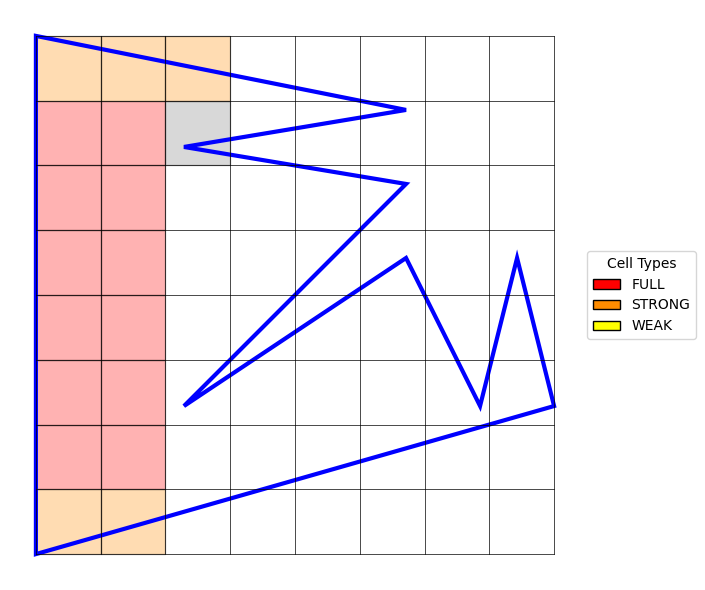

In [87]:
cell_type_to_color = {
    "FULL": "red",
    "STRONG": "#FF8C00",
    "WEAK": "yellow",
}
mbr_idxs, grid_info, x_s, y_s, poly, cells_square_type = read_create_poly_grid("../../build/poly_raster.txt")
plot_poly_grid(poly, x_s, y_s, cells_square_type, cell_type_to_color, False, False)

In [93]:
row_cell_polygons[(2,6)]

{'vertices_vectors': [[(4.625, 7.395833),
   (4.0, 7.5),
   (4.625, 7.604167),
   (4.625, 7.395833)],
  [(4.625, 7.25), (4.625, 8.125), (3.75, 8.125), (3.75, 7.25), (4.625, 7.25)]],
 'cell_type': None}

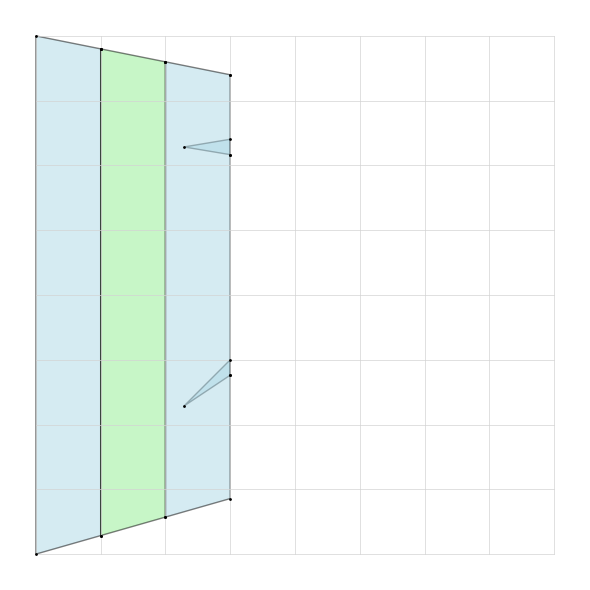

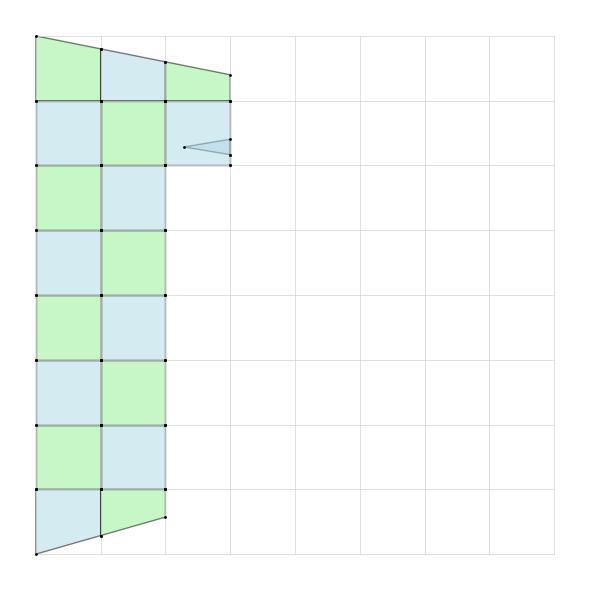

In [88]:
col_grid_info, col_mbr_idxs, col_cell_polygons = read_grid_without_cell_types("../../build/weiler_column_rasterization.txt")
x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)
plot_grid_without_cell_types(x_s, y_s, col_cell_polygons, True, True, False, (8,6)) 

row_grid_info, row_mbr_idxs, row_cell_polygons = read_grid_without_cell_types("../../build/weiler_row_rasterization.txt")
x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)
plot_grid_without_cell_types(x_s, y_s, row_cell_polygons, False, True, False, (8,6)) 

In [9]:

grid_info, mbr_idxs, cell_polygons = read_grid_without_cell_types("../../build/hodgman_column_rasterization.txt")
x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)
plot_grid_without_cell_types(x_s, y_s, cell_polygons, True, True, False) #, "hodgman_column_rasterization.svg")

grid_info, mbr_idxs, cell_polygons = read_grid_without_cell_types("../../build/hodgman_row_rasterization.txt")
x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)
plot_grid_without_cell_types(x_s, y_s, cell_polygons, False, True, False) #, "hodgman_row_rasterization.svg")



## Dataset Analysis

In [12]:
def polygon_area(vertices):
    n = len(vertices)
    area = 0.0
    
    for i in range(n-1):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        print(f"({x1}, {y1}) - ({x2}, {y2}): {x1 * y2 - y1 * x2}")
        area += x1 * y2 - y1 * x2
    
    return abs(area) / 2.0

def cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_polygon_cw(vertices):
    sum = 0
    n = len(vertices)
    for i in range(n):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % n]
        sum += (p2[0] - p1[0]) * (p2[1] + p1[1])
    return sum > 0
def is_clockwise(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    # Calculate the signed area
    area = 0.0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        area += (x2 - x1) * (y2 + y1)
    # Return True if the polygon is clockwise, False if counterclockwise
    return area > 0

# Function to check if a geometry is a polygon without holes
def is_simple_polygon(geom):
    if isinstance(geom, Polygon):
        print('aaa')
        return not geom.interiors
    elif isinstance(geom, MultiPolygon):
        print('bbbb')
        return all(not poly.interiors for poly in geom)
    return False


In [49]:
# analyze a dataset
in_file_path = "../../datasets/test.csv"
data = pd.read_csv(in_file_path, names=['WKT'])
geo_gdf = gpd.GeoDataFrame(data, geometry=data['WKT'].apply(wkt.loads))
# Filter polygons and multipolygons without holes
geo_gdf['is_simple'] = geo_gdf['geometry'].apply(is_simple_polygon)
geo_gdf['is_valid'] = geo_gdf['geometry'].apply(lambda geom: geom.is_valid)

# Apply the function to each geometry and add a new column 'is_cw'
geo_gdf['is_cw'] = geo_gdf['geometry'].apply(is_clockwise)
display(geo_gdf.head())

,WKT,geometry,is_simple,is_valid,is_cw
0,"POLYGON ((0 3, 0 4, 1 3, 1 4, 0 3))","POLYGON ((0.00000 3.00000, 0.00000 4.00000, 1....",False,False,False


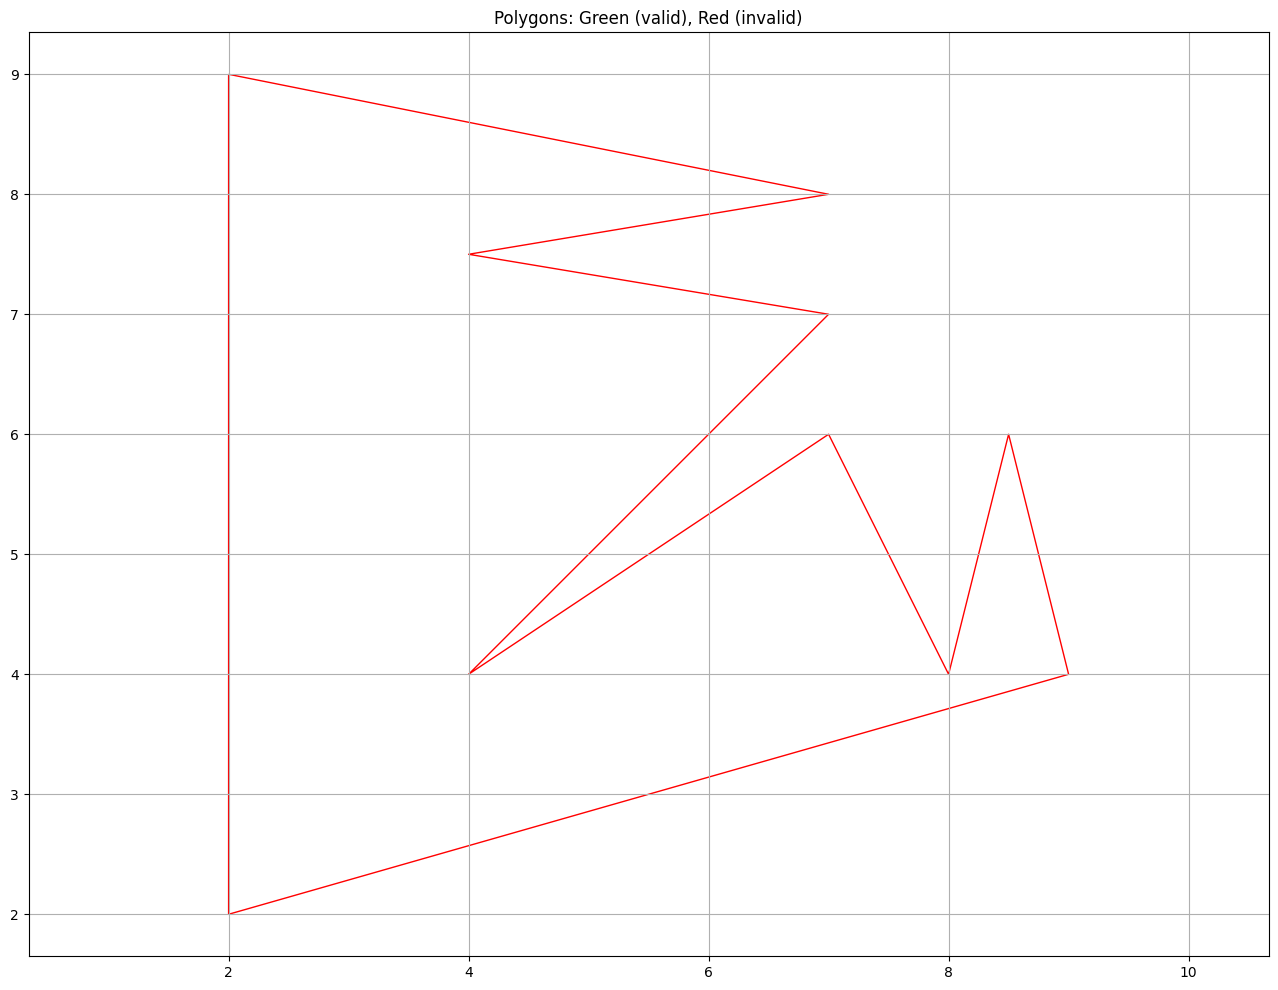

In [94]:
in_file_path = "../../datasets/test.csv"
data = pd.read_csv(in_file_path, names=['WKT'])
geo_gdf = gpd.GeoDataFrame(data, geometry=data['WKT'].apply(wkt.loads))

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

geo_gdf.plot(ax=ax, facecolor='none', edgecolor='red')
# Adjust axis limits and aspect ratio
# Get combined bounds of all geometries to determine proper axis limits
bounds = geo_gdf.total_bounds  # [minx, miny, maxx, maxy]
min_x, min_y, max_x, max_y = bounds

# Add padding to the bounds
padding = 0.05 * (max_x - min_x)
ax.set_xlim(min_x - padding, max_x + padding)
ax.set_ylim(min_y - padding, max_y + padding)

ax.set_aspect('equal', adjustable='datalim')

plt.title("Polygons: Green (valid), Red (invalid)")
plt.grid(True)
plt.show()

## Complete Rasterization read - plot functions

In [70]:



# works same way with read_polygons_grid 
# but for one polygon 
# thus we do not have different type cell of the 3 known 
def read_poly_grid(filename):
    ''' input file format:
    {xmin_idx} {ymin_idx} {xmax_idx} {ymax_idx}
    {xmin} {ymin} {step}
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    poly = []
    grid_cell_types = []
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()

        first_line_splited = lines[0].split()
        xmin_idx, ymin_idx, xmax_idx, ymax_idx = int(first_line_splited[0]), int(first_line_splited[1]), int(first_line_splited[2]), int(first_line_splited[3])
        mbr_idxs = {
            "xmin_idx": xmin_idx, 
            "ymin_idx": ymin_idx, 
            "xmax_idx": xmax_idx, 
            "ymax_idx": ymax_idx
        }

        sec_line_splited = lines[1].split()
        grid_xmin, grid_ymin, grid_xmax, grid_ymax, step = float(sec_line_splited[0]), float(sec_line_splited[1]), float(sec_line_splited[2]), float(sec_line_splited[3]), float(sec_line_splited[4])  
        grid_info = {
            'xmin': grid_xmin,
            'ymin': grid_ymin,
            'xmax': grid_xmax,
            'ymax': grid_ymax,
            'step': step
        }
        for line in lines[2:]:
            split_line = line.split()
            if len(split_line) == 3:
                i,j,cell_type = int(split_line[0]), int(split_line[1]), split_line[2]
                grid_cell_types.append((i,j,cell_type))
            if len(split_line) == 2:
                x = split_line[0]
                y = split_line[1]
                poly.append((float(x), float(y)))
    
    return mbr_idxs, grid_info, grid_cell_types, poly

def read_create_poly_grid(f_name):
    mbr_idxs, grid_info, grid_cell_types, poly = read_poly_grid(f_name)

    if mbr_idxs['xmin_idx'] > 0:
        xmin_idx = mbr_idxs['xmin_idx'] - 1 
    else:
        xmin_idx = mbr_idxs['xmin_idx']

    if mbr_idxs['ymin_idx'] > 0:
        ymin_idx = mbr_idxs['ymin_idx'] - 1 
    else:
        ymin_idx = mbr_idxs['ymin_idx'] 

    mbr_xmax = grid_info['xmin'] + mbr_idxs['xmax_idx'] * grid_info['step']
    mbr_ymax = grid_info['ymin'] + mbr_idxs['ymax_idx'] * grid_info['step']

    if mbr_xmax < grid_info['xmax']:
        xmax_idx = mbr_idxs['xmax_idx'] + 1 
    else:
        xmax_idx = mbr_idxs['xmax_idx']

    if mbr_ymax < grid_info['ymax']:
        ymax_idx = mbr_idxs['ymax_idx'] + 1 
    else:
        ymax_idx = mbr_idxs['ymax_idx']

    mbr_idxs = {
        "xmin_idx": xmin_idx, 
        "ymin_idx": ymin_idx, 
        "xmax_idx": xmax_idx, 
        "ymax_idx": ymax_idx
    }

    cells_square_type = []
    for j, i, cell_type in grid_cell_types:
        p0 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        p1 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p2 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p3 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        square = [p0, p1, p2, p3, p0]
        cells_square_type.append({
            "square": square,
            "cell_type": cell_type
        })

    x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)

    return mbr_idxs, grid_info, x_s, y_s, poly, cells_square_type

# apply the algorithm join in a cell having 2 cell types
def join_cell_type(ctype1, ctype2):
    if ctype1 == "FULL" or ctype2 == "FULL" or (ctype1 == "STRONG" and ctype2 == "STRONG"):
        return "TRUE HIT"
    else:
        return "INDECISIVE"
    
# read the grid info, the cell types and the polygons
# first line indicates the mbr of the polygons
# second line the grid info
# then we read the cell types
# and then the polygons
# regarding the cell types
# if find 2 of them in a cell we set 
# a new cell type : true hit/ indecisive based in their join
def read_polygons_grid(filename):
    ''' input file format:
    {xmin_idx} {ymin_idx} {xmax_idx} {ymax_idx}
    {grid_xmin} {grid_ymin} {grid_xmax} {grid_ymax} {step}
    {i} {j} {cell_type}
    {i'} {j'} {cell_type'}
    {i''} {j''} {cell_type''}
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    POLYGON
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    POLYGON
    .... '''
    polygons = []
    poly = []
    grid_cell_types = {}
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()

        first_line_splited = lines[0].split()
        xmin_idx, ymin_idx, xmax_idx, ymax_idx = int(first_line_splited[0]), int(first_line_splited[1]), int(first_line_splited[2]), int(first_line_splited[3])
        mbr_idxs = {
            "xmin_idx": xmin_idx, 
            "ymin_idx": ymin_idx, 
            "xmax_idx": xmax_idx, 
            "ymax_idx": ymax_idx
        }

        sec_line_splited = lines[1].split()
        grid_xmin, grid_ymin, grid_xmax, grid_ymax, step = float(sec_line_splited[0]), float(sec_line_splited[1]), float(sec_line_splited[2]), float(sec_line_splited[3]), float(sec_line_splited[4])  
        grid_info = {
            'xmin': grid_xmin,
            'ymin': grid_ymin,
            'xmax': grid_xmax,
            'ymax': grid_ymax,
            'step': step
        }
        for line in lines[2:]:
            split_line = line.split()

            if len(split_line) == 3:
                i,j,cell_type = int(split_line[0]), int(split_line[1]), split_line[2]
                prev_cell_type = grid_cell_types.get((i,j), None)
                if not prev_cell_type:
                    grid_cell_types[(i,j)] = cell_type
                else:
                    grid_cell_types[(i,j)] = join_cell_type(prev_cell_type, cell_type)

            elif len(split_line) == 2:
                x = split_line[0]
                y = split_line[1]
                poly.append((float(x), float(y)))
            
            elif len(split_line) == 1:
                polygons.append(poly)
                poly = []
    
    return mbr_idxs, grid_info, grid_cell_types, polygons

# read grid, cell types, polygons using read_polygons_grid
# extend the mbr of the polygons by one cell for each side
# if the extended side is inside the grid
# find the squares (5 coords) of each cell 
# and extract the rows, columns 
def read_create_polygons_grid(f_name):
    mbr_idxs, grid_info, grid_cell_types, polygons = read_polygons_grid(f_name)

    if mbr_idxs['xmin_idx'] > 0:
        xmin_idx = mbr_idxs['xmin_idx'] - 1 
    else:
        xmin_idx = mbr_idxs['xmin_idx']

    if mbr_idxs['ymin_idx'] > 0:
        ymin_idx = mbr_idxs['ymin_idx'] - 1 
    else:
        ymin_idx = mbr_idxs['ymin_idx'] 

    mbr_xmax = grid_info['xmin'] + mbr_idxs['xmax_idx'] * grid_info['step']
    mbr_ymax = grid_info['ymin'] + mbr_idxs['ymax_idx'] * grid_info['step']

    if mbr_xmax < grid_info['xmax']:
        xmax_idx = mbr_idxs['xmax_idx'] + 1 
    else:
        xmax_idx = mbr_idxs['xmax_idx']

    if mbr_ymax < grid_info['ymax']:
        ymax_idx = mbr_idxs['ymax_idx'] + 1 
    else:
        ymax_idx = mbr_idxs['ymax_idx']

    mbr_idxs = {
        "xmin_idx": xmin_idx, 
        "ymin_idx": ymin_idx, 
        "xmax_idx": xmax_idx, 
        "ymax_idx": ymax_idx
    }

    cells_square_type = []
    for (j, i), cell_type in grid_cell_types.items():
        
        p0 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        p1 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p2 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p3 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        square = [p0, p1, p2, p3, p0]
        cells_square_type.append({
            "square": square,
            "cell_type": cell_type
        })

    x_s, y_s = grid_cols_rows(mbr_idxs, grid_info)

    return mbr_idxs, grid_info, x_s, y_s, polygons, cells_square_type



def plot_poly_grid(polygon, x_s, y_s, cells_square_type, cell_type_to_color, show_points=True, show_axis_numbers=True, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Create the figure and axis
    
    # Create a meshgrid from x and y coordinates
    #X, Y = np.meshgrid(x_s, y_s)
    
    # Plot the vertical grid lines
    for i in range(len(x_s)):
        ax.plot([x_s[i]]*len(y_s), y_s, color='black', linestyle='-', linewidth=0.5)  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y_s)):
        ax.plot(x_s, [y_s[j]]*len(x_s), color='black', linestyle='-', linewidth=0.5)  # Horizontal lines


    for square_cell_type in cells_square_type:
        square = square_cell_type['square']
        cell_type = square_cell_type['cell_type']
        color = cell_type_to_color.get(cell_type, 'gray')  # Default to gray if cell_type not in the dict
        x, y = zip(*square)
        ax.fill(x, y, color, edgecolor='black', alpha=0.3)
        # if show_points:
        #     ax.scatter(x, y, color='black', s=10)

    # Plot the polygon
    polygon_patch = Polygon(polygon, fill=None, edgecolor='blue', linewidth=3)
    ax.add_patch(polygon_patch)

    if show_points:
        # Plot points at the vertices of the polygon
        polygon_x, polygon_y = zip(*polygon)
        ax.plot(polygon_x, polygon_y, 'ro', color='black')


    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    if show_axis_numbers:
        # Set axis labels and ticks
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(x_s)
        ax.set_yticks(y_s)
        plt.title('Complete Grid Plot with Polygon')
    else:
        # Hide axis labels and ticks
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # Hide numerical labels on the x and y axes
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the axis frame
        ax.axis('off')

    # Create legend
    legend_patches = [Patch(facecolor=color, edgecolor='black', label=cell_type) 
                      for cell_type, color in cell_type_to_color.items()]
    
    # Position the legend outside the plot
    ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Cell Types')

    # Adjust layout to make space for the legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.75)  # Adjust to make space on the right for the legend

    # # Set grid lines
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.savefig("raster.svg", format='svg', bbox_inches='tight')

    # Show plot
    plt.show()
    
# plot a grid of lines (y_s), columns(x_s)
# fill the grid cells with colors depending on the cell type of each cell 
# described by the cells_square_type.
# each cell type is mapped to a color based on cell_type_to_color
# if only_tr_hits_ind is true we fill only interesction ir indecisive cells
# each polygon is ploted with different color 
def plot_polygons_grid(polygons, x_s, y_s, cells_square_type, cell_type_to_color, show_points=True, show_axis_numbers=True, only_tr_hits_ind=False,figsize=(8,6)):
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    fig, ax = plt.subplots(figsize=figsize)  # Create the figure and axis
    
    # Create a meshgrid from x and y coordinates
    X, Y = np.meshgrid(x_s, y_s)
    
    # Plot the vertical grid lines
    for i in range(len(x_s)):
        ax.plot([x_s[i]]*len(y_s), y_s, color='black', linestyle='-', linewidth=0.5)  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y_s)):
        ax.plot(x_s, [y_s[j]]*len(x_s), color='black', linestyle='-', linewidth=0.5)  # Horizontal lines

    for square_cell_type in cells_square_type:
        square = square_cell_type['square']
        cell_type = square_cell_type['cell_type']
        if not only_tr_hits_ind or cell_type in ['TRUE HIT', 'INDECISVE']:
            color = cell_type_to_color.get(cell_type, 'black')  # Default to gray if cell_type not in the dict
            x, y = zip(*square)
            ax.fill(x, y, color, edgecolor='black', alpha=0.3)

    for idx, polygon in enumerate(polygons):
        # Plot the polygon
        color = colors[idx % len(colors)]
        polygon_patch = Polygon(polygon, fill=None, edgecolor=color, linewidth=3)
        ax.add_patch(polygon_patch)

        if show_points:
            # Plot points at the vertices of the polygon
            polygon_x, polygon_y = zip(*polygon)
            ax.plot(polygon_x, polygon_y, 'ro', color='black')


    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    if show_axis_numbers:
        # Set axis labels and ticks
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(x_s)
        ax.set_yticks(y_s)
        plt.title('Complete Grid Plot with Polygon')
    else:
        # Hide axis labels and ticks
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # Hide numerical labels on the x and y axes
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the axis frame
        ax.axis('off')

    # Create legend
    legend_patches = [Patch(facecolor=color, edgecolor='black', label=cell_type) 
                      for cell_type, color in cell_type_to_color.items()]
    
    # Position the legend outside the plot
    ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Cell Types')

    # Adjust layout to make space for the legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.75)  # Adjust to make space on the right for the legend

    # Set grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.savefig("costy_indecesive.svg", format='svg', bbox_inches='tight')

    plt.show()



In [ ]:
geo_gdf = gpd.GeoDataFrame(data, geometry=data['WKT'].apply(wkt.loads))

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

geo_gdf.plot(ax=ax, facecolor='none', edgecolor='red')
# Adjust axis limits and aspect ratio
# Get combined bounds of all geometries to determine proper axis limits
bounds = geo_gdf.total_bounds  # [minx, miny, maxx, maxy]
min_x, min_y, max_x, max_y = bounds

# Add padding to the bounds
padding = 0.05 * (max_x - min_x)
ax.set_xlim(min_x - padding, max_x + padding)
ax.set_ylim(min_y - padding, max_y + padding)

ax.set_aspect('equal', adjustable='datalim')

plt.title("Polygons: Green (valid), Red (invalid)")
plt.grid(True)
plt.show()

In [31]:
polygon = Polygon(poly)

# Create a GeoDataFrame
geo_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon])

# Plot the polygon
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot the GeoDataFrame
geo_gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# Get combined bounds of all geometries to determine proper axis limits
bounds = geo_gdf.total_bounds  # [minx, miny, maxx, maxy]
min_x, min_y, max_x, max_y = bounds

# Add padding to the bounds
padding = 0.05 * (max_x - min_x)
ax.set_xlim(min_x - padding, max_x + padding)
ax.set_ylim(min_y - padding, max_y + padding)

# Adjust aspect ratio
ax.set_aspect('equal', adjustable='datalim')

# Add title and grid
plt.title("Polygon Plot")
plt.grid(True)

# Show the plot
plt.show()

TypeError: Input must be valid geometry objects: Polygon355((-64.7652, 17.7596) ...)

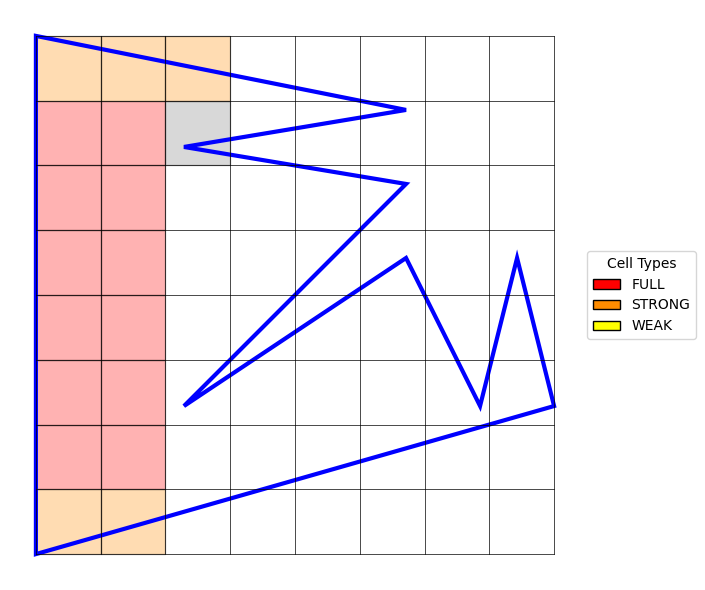

In [78]:
cell_type_to_color = {
    "FULL": "red",
    "STRONG": "#FF8C00",
    "WEAK": "yellow",
}
mbr_idxs, grid_info, x_s, y_s, poly, cells_square_type = read_create_poly_grid("../../build/poly_raster.txt")
plot_poly_grid(poly, x_s, y_s, cells_square_type, cell_type_to_color, False, False)

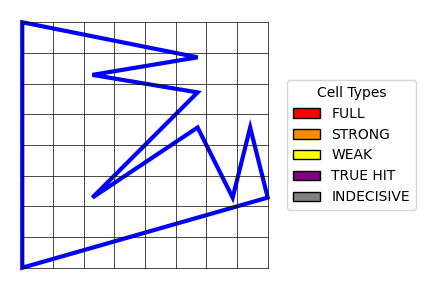

In [77]:
cell_type_to_color = {
    "FULL": "red",
    "STRONG": "#FF8C00",
    "WEAK": "yellow",
    "TRUE HIT": "purple",
    "INDECISIVE": "grey"
}
mbr_idxs, grid_info, x_s, y_s, polygons, cells_square_type = read_create_polygons_grid("../../build/polygons_grid.txt")
plot_polygons_grid(polygons, x_s, y_s, cells_square_type, cell_type_to_color, False, False, False, (4,3))

In [20]:
# grid_f_name = "../../build/clipped_vertices_cell_type.txt"
# grid = read_grid(grid_f_name)
# plot_grid(grid, cell_type_to_color, (8,6))

In [21]:
# poly = read_polygon("polygon.txt")
# print(poly)
# plot_polygon(poly[0], figsize=(6,4))